# NHK News Easy Hard Classifier

## Description
This model aims to classify a given input text in Japanese into one of two reading comprehension difficulty levels: easy or hard.

## Dataset
The dataset used is a wiki dump of the entire set of Japanese Wikipedia articles. The dataset was downloaded and pre-processed on my machine, but the resulting 

TODO:
- describe the dataset used
- describe the transformation pipeline
- describe the training methodology
- describe the deployment strategy
- conclude with interesting observations
- references

# Step 1. Load the dataset and annotate the training data

In [71]:
import pandas as pd

# Load NHK dataset
easy_news = pd.read_csv("../resources/nhk_news/easy_articles.csv")
hard_news = pd.read_csv("../resources/nhk_news/hard_articles.csv")

# Extract the article text
easy_texts = easy_news['texts']
hard_texts = hard_news['texts']
easy_texts_size = len(easy_texts)
hard_texts_size = len(hard_texts)

# Label each as easy (1) or hard (-1)
EASY = 1
HARD = -1
easy_targets = pd.Series(easy_texts_size * [EASY])
hard_targets = pd.Series(hard_texts_size * [HARD])

# Merge the dataset
# NOTE: ignore_index is used to allow index continuity 
X = pd.concat([easy_texts,   hard_texts],   ignore_index=True)
y = pd.concat([easy_targets, hard_targets], ignore_index=True)

# Step 2. Replace each word with its embedding

In [72]:
# Tokenize each sentence

# I use the MeCab POS tagger for tokenization as Japanese words aren't delimited by space.
#
# For example, "ロイヤルミルクティーはミルクティーよりもカロリーが高い"
#     Becomes:  ロイヤルミルクティー   は    ミルク    ティー    より    も     カロリー    が 高い
#
# This is based on MeCab's -Owakati dictionary, which is the same dictionary used during 
# the training of the pre-trained model

import MeCab

def tokenize(article):
    return tagger.parse(article).split()

tagger = MeCab.Tagger("-Owakati")

print("Before tokenization:")
print(X.head())
X = X.apply(tokenize)
print()
print("After tokenization:")
print(X.head())



Before tokenization:
0    国連のＦＡＯ＝国連食糧農業機関は、食べ物がないため栄養が足りなくて苦しんでいる人が世界に８億...
1    日本の政府は、ユネスコ＝ＵＮＥＳＣＯの世界遺産に「長崎の教会群とキリスト教関連遺産」を推薦す...
2    鯨をとることについて世界の国が話し合うＩＷＣの総会がスロベニアでありました。この会議でニュー...
3    １８日、東京都大田区の駐車場で猫の首を絞めて強い力で地面に投げたなどの理由で、３３歳の会社員...
4    １９日、アップルは新しいスマートフォン「ｉＰｈｏｎｅ６」を日本でも売り出しました。画面の大き...
Name: texts, dtype: object

After tokenization:
0    [国連, の, ＦＡＯ, ＝, 国連, 食糧, 農業, 機関, は, 、, 食べ物, が, ...
1    [日本, の, 政府, は, 、, ユネスコ, ＝, ＵＮＥＳＣＯ, の, 世界, 遺産, ...
2    [鯨, を, とる, こと, について, 世界, の, 国, が, 話し合う, ＩＷＣ, の...
3    [１, ８, 日, 、, 東京, 都, 大田, 区, の, 駐車, 場, で, 猫, の, ...
4    [１, ９, 日, 、, アップル, は, 新しい, スマートフォン, 「, ｉＰｈｏｎｅ,...
Name: texts, dtype: object


In [73]:
# Get embedding for each word

# We construct article embeddings based on the embeddings of each individual token
# NOTE: A pre-trained model was used since I didn't have the resources to train a
#       word2vec model on a 5GB dataset at the time.

import gensim

model_path = "word2vec/pretrained/word2vec.model.bin"

# 100-dimension embeddings
model = gensim.models.Word2Vec.load(model_path)
    
def substitute_for_embeddings(article):
    article_embedding = []
    for token in article:
        # Filter out any characters which don't have an embedding in the model
        if token in model.wv:
            article_embedding.append(model.wv[token])
    return np.array(article_embedding)

X = X.apply(substitute_for_embeddings)

print(X.head())




0    [[-0.5994279, 0.89275813, -1.3500179, 1.144231...
1    [[-1.7453705, -0.45321932, -0.62361723, -2.899...
2    [[0.10632134, -1.6554157, 1.1372911, -0.930083...
3    [[-1.5607809, -4.779662, -1.433639, -1.4902706...
4    [[-1.5607809, -4.779662, -1.433639, -1.4902706...
Name: texts, dtype: object


# Step 3. Analyse dataset imbalance

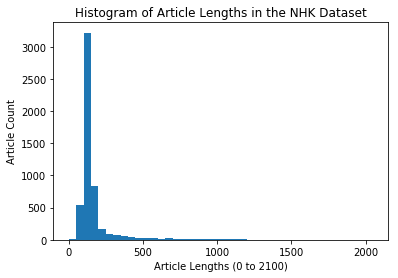

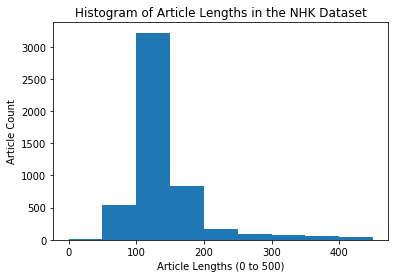

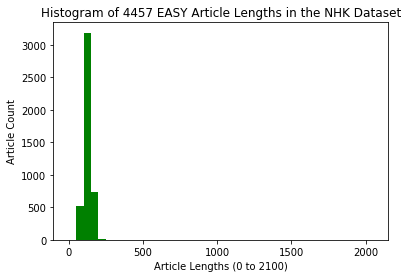

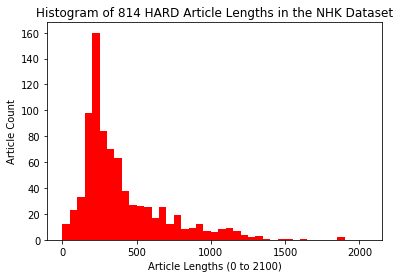

In [80]:
import matplotlib.pyplot as plt

### Finding out the range of article lengths
### It turns out the min. length is 0, and the max. length is 2092
article_lengths = [ len(article) for article in X ]
# print(min(article_lengths))
# print(max(article_lengths))

### Here is a cursory glance at a histogram modelling the collection of article lengths
n, bins, patches = plt.hist(article_lengths, bins=range(0, 2100, 50), range=(0, 2100))
plt.xlabel('Article Lengths (0 to 2100)')
plt.ylabel('Article Count')
plt.title('Histogram of Article Lengths in the NHK Dataset')
plt.show()

### The first graph appears skewed to the right. Let's centre in on the left a bit more.
n, bins, patches = plt.hist(article_lengths, bins=range(0, 500, 50), range=(0, 500))
plt.xlabel('Article Lengths (0 to 500)')
plt.ylabel('Article Count')
plt.title('Histogram of Article Lengths in the NHK Dataset')
plt.show()

### From this, we can infer that the majority of articles lie in the 75-225 range.
### I have a feeling shorter articles are more likely to fall in the "Easy" category
### while longer articles are more "Hard". Let's plot another graph showing how each
### category is distributed in terms of article length.

easy_article_lengths = article_lengths[:easy_texts_size]
hard_article_lengths = article_lengths[easy_texts_size:]

n, bins, patches = plt.hist(easy_article_lengths, bins=range(0, 2100, 50), range=(0, 2100), color="g")
plt.xlabel('Article Lengths (0 to 2100)')
plt.ylabel('Article Count')
plt.title(f"Histogram of {easy_texts_size} EASY Article Lengths in the NHK Dataset")
plt.show()

n, bins, patches = plt.hist(hard_article_lengths, bins=range(0, 2100, 50), range=(0, 2100), color="r")
plt.xlabel('Article Lengths (0 to 2100)')
plt.ylabel('Article Count')
plt.title(f"Histogram of {hard_texts_size} HARD Article Lengths in the NHK Dataset")
plt.show()



        

# Revise the dataset

As you can see from the previous analysis, the dataset is skewed toward easy articles. This means we need to retain as many hard article samples. Since hard articles are generally longer in character count, we may be tempted to prune a portion of them so that our model can deal with fewer layers. However, since our goal is to keep as many hard article samples, I think a better solution would be to segment the articles into sentences. Therefore, we have to repeat the pipeline from the beginning:

In [87]:
def segment_into_sentences(articles):
    
    # This character is essentially a period/full-stop i.e. "."
    delimiter = "。"
    
    segmented = [] 
    for article in articles:
        for segment in article.split(delimiter):
            segmented.append(segment)
            
    return pd.Series(segmented)

# NOTE: easy_news and hard_news are from the very first cell
easy_texts = segment_into_sentences(easy_news['texts'])
hard_texts = segment_into_sentences(hard_news['texts'])


####### NOTE: The following is reproduced code up until the padding stage ######

easy_texts_size = len(easy_texts)
hard_texts_size = len(hard_texts)

# Label each as easy (1) or hard (-1)
EASY = 1
HARD = -1
easy_targets = pd.Series(easy_texts_size * [EASY])
hard_targets = pd.Series(hard_texts_size * [HARD])

# Merge the dataset
# NOTE: ignore_index is used to allow index continuity 
X = pd.concat([easy_texts,   hard_texts],   ignore_index=True)
y = pd.concat([easy_targets, hard_targets], ignore_index=True)

# Tokenize
X = X.apply(tokenize)

# Embeddings
X = X.apply(substitute_for_embeddings)

# Step 3. Analyse dataset imbalance (Continuation)

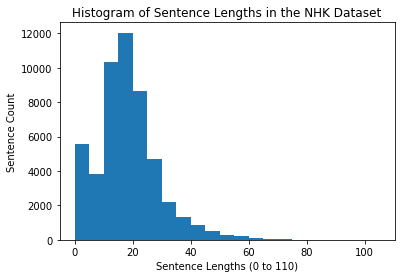

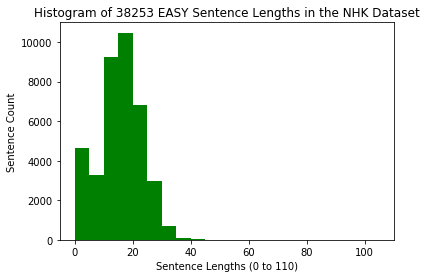

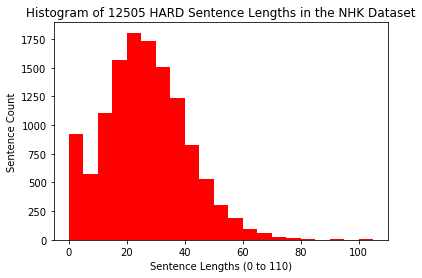

In [88]:
### Here, we repeat the data analysis to see the effect of segmenting text

### Finding out the range of sentence lengths
### It turns out the min. length is 0, and the max. length is 108
sentence_lengths = [ len(article) for article in X ]
# print(min(sentence_lengths))
# print(max(sentence_lengths))

### Here is a cursory glance at a histogram modelling the collection of sentence lengths
n, bins, patches = plt.hist(sentence_lengths, bins=range(0, 110, 5), range=(0, 110))
plt.xlabel('Sentence Lengths (0 to 110)')
plt.ylabel('Sentence Count')
plt.title('Histogram of Sentence Lengths in the NHK Dataset')
plt.show()

### Here is a comparison of the distribution of EASY sentences versus HARD sentences

easy_sentence_lengths = sentence_lengths[:easy_texts_size]
hard_sentence_lengths = sentence_lengths[easy_texts_size:]

n, bins, patches = plt.hist(easy_sentence_lengths, bins=range(0, 110, 5), range=(0, 110), color="g")
plt.xlabel('Sentence Lengths (0 to 110)')
plt.ylabel('Sentence Count')
plt.title(f"Histogram of {easy_texts_size} EASY Sentence Lengths in the NHK Dataset")
plt.show()

n, bins, patches = plt.hist(hard_sentence_lengths, bins=range(0, 110, 5), range=(0, 110), color="r")
plt.xlabel('Sentence Lengths (0 to 110)')
plt.ylabel('Sentence Count')
plt.title(f"Histogram of {hard_texts_size} HARD Sentence Lengths in the NHK Dataset")
plt.show()


## Analysis
It seems like the segmentation has somewhat improved the imbalance in the dataset but not completely. I am apprehensive to do any further segmentation since the maximum sentence length  is currently at 108, which is by NLP standards quite resonable. The eventual sequential model would be 100 or so cells long. 

As a side note, further down the road I would like to perform unsupervised learning techniques in an attempt to "decompose" the easy and hard categories into sub-categories. This resembles modern language proficiency level grading systems e.g. the JLPT (Japanese language proficiency test) grades are based on 5 levels - N1 through to N5. Is it possible to come up with a new grading system based on machine learning, as opposed to whatever criteria is being used at the moment?

In [ ]:
# Step 3. Split the dataset into a training and validation set
# from sklearn.model_selection import train_test_split

# train_X, train_y, val_X, val_y = train_test_split(X, y, test_size=0.2, random_state=1)